# Pressure - $\eta$ transforms
Find optimal parameters for transforming Asilomar Small-Scale Array pressure measurements to sea-surface elevation $\eta$. Test both regular linear transfer function and the $\kappa_\mathrm{rms}$-based methods of Martins et al. (2021, JPO).

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import scipy.stats as stats
from scipy import signal
from scipy.io import loadmat
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
from PyPDF2 import PdfFileMerger, PdfFileReader
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import transfer_functions as rptf
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import plotting as rppl

# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')
figdir = os.path.join(data_root, 'img', 'p2eta_opt')


Test different transfer function parameters for pressure-$\eta$ reconstruction and compare against acoustic surface track (AST) signal from Nortek Signature 1000 ADCPs around the SSA rock.

In [2]:
mids = ['C1', 'C3', 'C6'] # Mooring IDs
sers = ['103088', '103094', '103110'] # Serial numbers

# Define segment timestamps
t0 = pd.Timestamp('2022-07-12 00:00') # start date
t1 = pd.Timestamp('2022-07-14 12:00') # start date
nm = 20 # time series length (number of minutes)
tfreq = '{}T'.format(nm) # Time step between timestamps in date range
date_range = pd.date_range(t0, t1, freq='1D')

# K_rms transformation parameters
tail_method = 'constant'
fix_ends = False
fmax = 1.0

for date in date_range:
    print('Date: ', str(date))
    datestr_short = ''.join(str(date.date()).split('-')) # Datestr in format yyyymmdd
    # Split date into nm-minute segments
    rec_range = pd.date_range(date, date+pd.Timedelta(days=1), freq=tfreq)
    # Iterate over nm-minute segments and transform pressure -> eta and plot
    for cnt, t0s in tqdm(enumerate(rec_range)):
        # Segment end time
        t1s = t0s + pd.Timedelta(minutes=nm)
        if t0s > t1:
            # Don't go past requested end time
            continue
        # Iterate over mooring IDs and serial numbers
        for i, (mid, ser) in enumerate(zip(mids, sers)):
            # Signature velocity netcdf directory
            veldir = os.path.join(data_root, '{}'.format(ser)) 
            # Check if output csv file exists
            csvdir = os.path.join(veldir, 'p2eta')
            # Check if directory exists; if not, make dir
            if not os.path.isdir(csvdir):
                os.mkdir(csvdir)
            # Output time series csv filename
            fn_csv = os.path.join(csvdir, 'p2eta_{}_{}_{:03d}_tail_{}.csv'.format(
                ser, datestr_short, cnt, tail_method))
            # Check if output spectral netcdf file exists
            ncdir = os.path.join(csvdir, 'spectra')
            # Check if directory exists; if not, make dir
            if not os.path.isdir(ncdir):
                os.mkdir(ncdir)
            # Output spectra netcdf filename
            fn_nc = os.path.join(ncdir, 'p2eta_spec_{}_{}_{:03d}_tail_{}.nc'.format(
                ser, datestr_short, cnt, tail_method))
            if not os.path.isfile(fn_csv) or not os.path.isfile(fn_nc):
                # List netcdf files in veldir
                fns_v = sorted(glob.glob(os.path.join(veldir, 'Asilomar_*.nc')))
                if str((t0s - pd.Timedelta(minutes=nm/2)).date()) != str(t0s.date()):
                    # Combine current and previous dates
                    t00s = (t0s - pd.Timedelta(minutes=nm/2)).date() # Previous date
                    # Read Signature velocity dataset for current date
                    datestr = '{}{:02d}{:02d}'.format(t0s.year, t0s.month, t0s.day)
                    fn_sig = [f for f in fns_v if datestr in f]
                    # Check if start date is June 30
                    sk1 = np.logical_and(np.logical_or(mid=='C3', mid=='C6'), 
                                         str(t0s.date())=='2022-06-30')
                    if sk1:
                        fn_sig = [f for f in fns_v if '20220701' in f]
                        # Read current date's dataset
                        dsc = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
                        # Read Signature velocity dataset for previous date
                        datestr0 = '{}{:02d}{:02d}'.format(t00s.year, t00s.month, t00s.day)
                        fn_sig0 = [f for f in fns_v if datestr0 in f]
                        # Read previous date's dataset
                        ds0 = xr.decode_cf(xr.open_dataset(fn_sig0[0], decode_coords='all'))
                        # Concatenate current+previous datasets
                        ds = xr.concat([ds0, dsc], dim='time')
                    # Check if start date is July 1
                    sk2 = np.logical_and(np.logical_or(mid=='C3', mid=='C6'), 
                                         str(t0s.date())=='2022-07-01')
                    if sk2:
                        # 30 Jun and 1 Jul in the same file
                        ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
                    else:
                        # Read current date's dataset
                        dsc = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
                        # Read Signature velocity dataset for previous date
                        datestr0 = '{}{:02d}{:02d}'.format(t00s.year, t00s.month, t00s.day)
                        fn_sig0 = [f for f in fns_v if datestr0 in f]
                        # Read previous date's dataset
                        ds0 = xr.decode_cf(xr.open_dataset(fn_sig0[0], decode_coords='all'))
                        # Concatenate current+previous datasets
                        ds = xr.concat([ds0, dsc], dim='time')
                elif str((t1s + pd.Timedelta(minutes=nm/2)).date()) != str(t1s.date()):
                    # Combine current and following dates
                    t11s = (t1s + pd.Timedelta(minutes=nm/2)).date() # Following date
                    # Read Signature velocity dataset for current date
                    datestr = '{}{:02d}{:02d}'.format(t0s.year, t0s.month, t0s.day)
                    fn_sig = [f for f in fns_v if datestr in f]
                    # In some cases, 30.6 and 1.7 dates are combined into one netcdf file
                    sk = np.logical_and(np.logical_or(mid=='C3', mid=='C6'), 
                                        str(t0s.date())=='2022-06-30')
                    if sk:
                        fn_sig = [f for f in fns_v if '20220701' in f]
                        # 30 June and 1 July in the same file
                        ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
                    else:
                        # Read current date's dataset
                        dsc = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
                        # Read Signature velocity dataset for following date
                        datestr1 = '{}{:02d}{:02d}'.format(t11s.year, t11s.month, t11s.day)
                        fn_sig1 = [f for f in fns_v if datestr1 in f]
                        # Read following date's dataset
                        ds1 = xr.decode_cf(xr.open_dataset(fn_sig1[0], decode_coords='all'))
                        # Concatenate current+following datasets
                        ds = xr.concat([dsc, ds1], dim='time')
                else:
                    # Read Signature velocity dataset for current date
                    datestr = '{}{:02d}{:02d}'.format(t0s.year, t0s.month, t0s.day)
                    fn_sig = [f for f in fns_v if datestr in f]
                    # In some cases, 30.6 and 1.7 dates are combined into one netcdf file
                    sk = np.logical_and(np.logical_or(mid=='C3', mid=='C6'), 
                                        str(t0s.date())=='2022-06-30')
                    if not sk:
                        ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
                    else:
                        fn_sig = [f for f in fns_v if '20220701' in f]
                        ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
                # Take requested segment from dataset
                seg = ds.sel(time=slice(t0s, t1s)).copy() # Segment slice
                # Directional wave spectra
                # Use AST and pressure for spectra
                eta_ast = seg.ASTd_eta.values # AST
                eta_hyd = seg.eta_hyd.values # hydrostatic surface
                z_hyd = seg.z_hyd.values # hydrostatic pressure head
                depth = np.mean(z_hyd)
                time_index = seg.time.values # Time index for dataframe
                # Save eta products to dataframe
                dfe = pd.DataFrame(data={'eta_hyd': eta_hyd, 'eta_ast': eta_ast},
                                   index=time_index)
                # Rename index
                dfe.index = dfe.index.rename('time')
                # Estimate AST and hydrostatic spectra
                dss = rpws.spec_uvz(z=eta_ast, fs=4, wsec=256, fmerge=3)
                # Rename AST spectrum variable
                dss = dss.rename(name_dict={'Ezz':'East'})
                # Estimate hyrostatic spectrum
                dssh = rpws.spec_uvz(z=eta_hyd, fs=4, wsec=256, fmerge=3)
                # Save timestamp in netcdf
                dss = dss.assign_coords(time=t0s.floor('20T'))
                # Save hyd spec to dss
                dss['Ehyd'] = (['freq'], dssh.Ezz.values)
                # Reconstruct eta from pressure for different cut-off frequencies
                fcs = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5] # cut-off freqs (Hz)
                lss = ['-', '--', ':'] # Linestyles for fc values
                for fi,fc in enumerate(fcs):
                    # Initialize TRF object
                    trf = rptf.TRF(fs=4, zp=0.3)
                    # Regular linear reconstruction (returns depth)
                    z_lin = trf.p2z_lin(z_hyd, fmax=fc)
                    eta_lin = z_lin - depth
                    # Compute bispectrum and use it to get K_rms
                    dsb = rpws.bispectrum(eta_hyd, fs=4, h0=depth, return_krms=True)
                    krms = dsb.k_rms.values
                    f_krms = dsb.freq1.values
                    # (Non)linear K_rms reconstructions
                    eta_lin_krms, eta_nl_krms = trf.p2eta_krms(eta_hyd, h0=depth, fc=fc, 
                        fcmax_allowed=fc, f_krms=f_krms, krms=krms, return_nl=True, fmax=fmax, 
                        fp=(1 / dss.Tp_Y95.item()), fix_ends=fix_ends, tail_method=tail_method)
                    # Fix end points with overlapping reconstructions
                    t0ob = t0s - pd.Timedelta(minutes=(nm/2)) # half period before t0
                    t1ob = t0s + pd.Timedelta(minutes=(nm/2)) # half period before t1
                    # Get hydrostatic signal 
                    seg0 = ds.sel(time=slice(t0ob, t1ob)).copy() # Overlap segment slice
                    times0 = seg0.time.values
                    z_hyd0 = seg0.z_hyd.values
                    eta_hyd0 = z_hyd0 - np.mean(z_hyd0)
                    # Reconstruct linear
                    z_lin0 = trf.p2z_lin(z_hyd0, fmax=fc)
                    eta_lin0 = z_lin0 - depth
                    # Reconstruct (non)linear K_rms
                    eta_lin_krms0, eta_nl_krms0 = trf.p2eta_krms(eta_hyd0, h0=depth, fc=fc, 
                        fcmax_allowed=fc, f_krms=f_krms, krms=krms, return_nl=True, fmax=fmax, 
                        fp=(1 / dss.Tp_Y95.item()), fix_ends=fix_ends, tail_method=tail_method)
                    # Also get half period after
                    t0oa = t1s - pd.Timedelta(minutes=(nm/2)) # half period before t0
                    t1oa = t1s + pd.Timedelta(minutes=(nm/2)) # half period before t1
                    # Get hydrostatic signal 
                    seg1 = ds.sel(time=slice(t0oa, t1oa)).copy() # Overlap segment slice
                    times1 = seg1.time.values
                    z_hyd1 = seg1.z_hyd.values
                    eta_hyd1 = z_hyd1 - np.mean(z_hyd1)
                    # Reconstruct linear
                    z_lin1 = trf.p2z_lin(z_hyd1, fmax=fc)
                    eta_lin1 = z_lin1 - depth
                    # Reconstruct (non)linear K_rms
                    eta_lin_krms1, eta_nl_krms1 = trf.p2eta_krms(eta_hyd1, h0=depth, fc=fc, 
                        fcmax_allowed=fc, f_krms=f_krms, krms=krms, return_nl=True, fmax=fmax, 
                        fp=(1 / dss.Tp_Y95.item()), fix_ends=fix_ends, tail_method=tail_method)
                    # Make dataframes and merge end points
                    dfm0 = pd.DataFrame(data={'eta_lin': eta_lin0, 
                                              'eta_lin_krms':eta_lin_krms0, 
                                              'eta_nl_krms':eta_nl_krms0, 
                                              },
                                        index=times0)
                    dfm0.index = dfm0.index.rename('time')
                    dfm = pd.DataFrame(data={'eta_lin': eta_lin, 
                                             'eta_lin_krms':eta_lin_krms, 
                                             'eta_nl_krms':eta_nl_krms, 
                                             },
                                        index=time_index)
                    dfm.index = dfm.index.rename('time')
                    dfm1 = pd.DataFrame(data={'eta_lin': eta_lin1, 
                                             'eta_lin_krms':eta_lin_krms1, 
                                             'eta_nl_krms':eta_nl_krms1, 
                                             },
                                        index=times1)
                    dfm1.index = dfm1.index.rename('time')
                    # Merge left and right dataframes with original (middle)
                    dfl = dfm.join(dfm0, on='time', how='left', lsuffix='_o', rsuffix='_l')
                    dfr = dfm.join(dfm1, on='time', how='left', lsuffix='_o', rsuffix='_r')
                    # Use first 100 samples from left dataframe to fix start edge effects
                    eta_lin_m = np.concatenate((dfl['eta_lin_l'].iloc[:100], 
                                                dfl['eta_lin_o'].iloc[100:]))
                    eta_lin_krms_m = np.concatenate((dfl['eta_lin_krms_l'].iloc[:100], 
                                                    dfl['eta_lin_krms_o'].iloc[100:]))
                    eta_nl_krms_m = np.concatenate((dfl['eta_nl_krms_l'].iloc[:100], 
                                                    dfl['eta_nl_krms_o'].iloc[100:]))
                    # Use last 100 samples from right dataframe to fix end edge effects
                    eta_lin_m = np.concatenate((eta_lin_m[:-100], dfr['eta_lin_r'].iloc[-100:]))
                    eta_lin_krms_m = np.concatenate((eta_lin_krms_m[:-100], 
                                                    dfr['eta_lin_krms_r'].iloc[-100:]))
                    eta_nl_krms_m = np.concatenate((eta_nl_krms_m[:-100], 
                                                    dfr['eta_nl_krms_r'].iloc[-100:]))
                    # Save reconstructions to dataframe
                    dfe['etal-{}'.format(fc)] = eta_lin_m
                    dfe['etalk-{}'.format(fc)] = eta_lin_krms_m
                    dfe['etank-{}'.format(fc)] = eta_nl_krms_m
                    # Estimate spectra
                    dssl = rpws.spec_uvz(eta_lin_m, fs=4)
                    dss['El-{}'.format(fc)] = (['freq'], dssl.Ezz.values)
                    dsslk = rpws.spec_uvz(eta_lin_krms_m, fs=4)
                    dss['Elk-{}'.format(fc)] = (['freq'], dsslk.Ezz.values)
                    dssnk = rpws.spec_uvz(eta_nl_krms_m, fs=4)
                    dss['Enk-{}'.format(fc)] = (['freq'], dssnk.Ezz.values)

                # Save to csv
                dfe.to_csv(fn_csv)
                # Save depth to dss
                dss['depth'] = depth
                # Save to netcdf
                dss.to_netcdf(fn_nc)
            else:
                # Read pre-saved time series and spectra
                dfe = pd.read_csv(fn_csv, parse_dates=['time']).set_index('time')
                dss = xr.open_dataset(fn_nc, decode_coords='all')

        # Timeseries/spectra figure filename
        fn_fig = os.path.join(figdir, 'p2eta_comp_c136_{}_{:03d}_tail_{}.pdf'.format(
            datestr_short, cnt, tail_method))
        # Check if figure already exists; if not, plot
        if not os.path.isfile(fn_fig):
            # Initialize figure
            fig, axes = plt.subplots(figsize=(9,7), nrows=3, ncols=2, sharex='col', sharey='col',
                                    gridspec_kw={'width_ratios': [3, 1]}, constrained_layout=True)
            # Iterate over mooring IDs and serial numbers
            for i, (mid, ser) in enumerate(zip(mids, sers)):
                # Signature velocity netcdf directory
                veldir = os.path.join(data_root, '{}'.format(ser)) 
                # Check if output csv file exists
                csvdir = os.path.join(veldir, 'p2eta')
                # Output time series csv filename
                fn_csv = os.path.join(csvdir, 'p2eta_{}_{}_{:03d}_tail_{}.csv'.format(
                    ser, datestr_short, cnt, tail_method))
                # Check if output spectral netcdf file exists
                ncdir = os.path.join(csvdir, 'spectra')
                # Output spectra netcdf filename
                fn_nc = os.path.join(ncdir, 'p2eta_spec_{}_{}_{:03d}_tail_{}.nc'.format(
                    ser, datestr_short, cnt, tail_method))
                # Read pre-saved csv and netcdf files
                dfe = pd.read_csv(fn_csv, parse_dates=['time']).set_index('time')
                dss = xr.open_dataset(fn_nc)
                depth = dss.depth.item()

                # Plot time series and spectra
                for fi,fc in enumerate([0.25, 0.3, 0.35]):
                    # Plot reconstructed eta and spectra
                    dfe['etal-{}'.format(fc)].plot(ax=axes[i,0], color='#2E86AB', linestyle=lss[fi],
                                                label='_', linewidth=0.8)
                    dfe['etalk-{}'.format(fc)].plot(ax=axes[i,0], color='#A23B72', linestyle=lss[fi],
                                                    label='_', linewidth=0.8)
                    dfe['etank-{}'.format(fc)].plot(ax=axes[i,0], color='#F18F01', linestyle=lss[fi],
                                                    label='_', linewidth=0.8)
                    # Spectra
                    dss['El-{}'.format(fc)].plot(ax=axes[i,1], color='#2E86AB', linestyle=lss[fi],
                        label=r'$\eta_\mathrm{l}$, $f_\mathrm{c}$'+'={}'.format(fc),
                        linewidth=0.8,
                        )
                    dss['Elk-{}'.format(fc)].plot(ax=axes[i,1], color='#A23B72', linestyle=lss[fi],
                        label=r'$\eta_\mathrm{l, krms}$, $f_\mathrm{c}$'+'={}'.format(fc),
                        linewidth=0.8,
                        )
                    dss['Enk-{}'.format(fc)].plot(ax=axes[i,1], color='#F18F01', linestyle=lss[fi],
                        label=r'$\eta_\mathrm{nl, krms}$, $f_\mathrm{c}$'+'={}'.format(fc),
                        linewidth=0.8,
                        )
                # Also plot AST eta and spectrum
                dfe['eta_ast'].plot(ax=axes[i,0], color='k', label=r'$\eta_\mathrm{AST}$')
                dss['East'].plot(ax=axes[i,1], color='k')
                # Annotate mooring ID and depth
                axes[i,0].annotate('{} depth={:.2f}m'.format(mid, depth), xy=(0.01, 0.9), 
                                xycoords='axes fraction', fontsize=10)
                axes[i,0].set_xlabel(None) # No xlabel
                axes[i,0].set_ylabel(r'$\eta$ [m]')
                axes[i,0].margins(x=0)
                # Set spectrum plot axes to semilog-y scale and zoom in to mid frequencies
                axes[i,1].set_yscale('log')
                axes[i,1].set_xlim([0.1, 0.5])
                axes[i,1].set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
                axes[i,1].set_ylim([0.01, dss['East'].max() + 0.5])
                # Legend on right
                axes[i,1].legend(ncols=1, fontsize=7, loc='center left', bbox_to_anchor=(1,0.5))
                axes[i,1].set_title(None) # No title
            # AST legend in 0,0
            axes[0,0].legend(ncols=1, fontsize=7, loc='upper right')
            # Title with date and time
            axes[0,0].set_title('{}-{}'.format(str(t0s), str(t1s.time())))

            # Save and close figure
            plt.tight_layout()
            plt.savefig(fn_fig, bbox_inches='tight', dpi=300)
            plt.close()

print(' ')
print('Done.')


Date:  2022-07-12 00:00:00


0it [00:00, ?it/s]

Date:  2022-07-13 00:00:00


0it [00:00, ?it/s]

Date:  2022-07-14 00:00:00


0it [00:00, ?it/s]

 
Done.


Get zero-crossing wave and crest heights from different reconstructions.

In [2]:
mids = ['C1', 'C3', 'C6'] # Mooring IDs
sers = ['103088', '103094', '103110'] # Serial numbers
tail_method = 'constant' # K_rms reconstruction tail method
fcs = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5] # High-frequency cutoffs
prs = ['etal', 'etalk', 'etank'] # Reconstruction products

# Define start and end times
t0 = pd.Timestamp('2022-06-26 00:00:00')
t1 = pd.Timestamp('2022-07-14 11:20:00')

# Iterate over mooring IDs and find all timeseries-reconstruction csv files
for i, (mid, ser) in enumerate(zip(mids, sers)):
    print('Mooring ID: ', mid)
    # Initialize dicts for wave and crest heights
    Hws = {'H-{}-{}'.format(pr, fc): [] for pr in prs for fc in fcs}
    # Add hyd & ast
    Hws['H-hyd'] = []
    Hws['H-ast'] = []
    Hcs = {'C-{}-{}'.format(pr, fc): [] for pr in prs for fc in fcs}
    # Add hyd & ast
    Hcs['C-hyd'] = []
    Hcs['C-ast'] = []
    timestamps = [] # List to store timestamps for dataframe index
    # Signature velocity netcdf directory
    veldir = os.path.join(data_root, '{}'.format(ser)) 
    csvdir = os.path.join(veldir, 'p2eta')
    # Define output dir. for csv files
    zcdir = os.path.join(csvdir, 'zero_crossings')
    if not os.path.isdir(zcdir):
        os.mkdir(zcdir)
    # Output csv filenames
    fn_out_H = os.path.join(zcdir, 'p2eta_{}_{}_waveheight.csv'.format(mid, ser))
    fn_out_C = os.path.join(zcdir, 'p2eta_{}_{}_crestheight.csv'.format(mid, ser))
    # List all csv files w/ reconstructed timeseries
    fns_csv = sorted(glob.glob(os.path.join(csvdir, 'p2eta*.csv')))
    # Iterate over csv files
    for fi,fn in enumerate(fns_csv):
        # Read spectrum netcdf file
        dfe = pd.read_csv(fn, parse_dates=['time']).set_index('time')
        # Check start/end times
        if dfe.index[0] < t0:
            # Skip earlier than requested start time
            continue
        if dfe.index[-1] > t1:
            # Skip later than requested end time
            continue
        # Use zero-crossings from hydrostatic surface elevation (smoothest?)
        zch, Hw, Hc, Ht = rpzc.get_waveheights(dfe['eta_hyd'].values)
        Hws['H-hyd'].extend(Hw)
        Hcs['C-hyd'].extend(Hc)
        timestamps.extend(dfe.index[zch[:-1]])
        # AST wave/crest heights
        _, Hw, Hc, Ht = rpzc.get_waveheights(dfe['eta_ast'].values, zero_crossings=zch)
        Hws['H-ast'].extend(Hw)
        Hcs['C-ast'].extend(Hc)
        # Compute wave/crest heights for different products
        for fc in fcs:
            for pr in prs:
                # eta-lin wave/crest heights
                seg = dfe['{}-{}'.format(pr, fc)].values
                _, Hw, Hc, Ht = rpzc.get_waveheights(seg, zero_crossings=zch)
                Hws['H-{}-{}'.format(pr, fc)].extend(Hw)
                Hcs['C-{}-{}'.format(pr, fc)].extend(Hc)
    # Combine wave height dicts to pd.DataFrame
    dfh = pd.DataFrame.from_dict(data=Hws)
    dfh.index = np.array(timestamps)
    dfh.index = dfh.index.rename('time')
    # Save to csv
    if os.path.isfile(fn_out_H):
        dfh.to_csv(fn_out_H)
    # Same for crest heights
    dfc = pd.DataFrame.from_dict(data=Hcs)
    dfc.index = np.array(timestamps)
    dfc.index = dfc.index.rename('time')
    # Save to csv
    if os.path.isfile(fn_out_C):
        dfc.to_csv(fn_out_C)
    
print(' ')
print('Done. ')

Mooring ID:  C1
Mooring ID:  C3
Mooring ID:  C6
 
Done. 


Compare AST spectra to reconstructions.

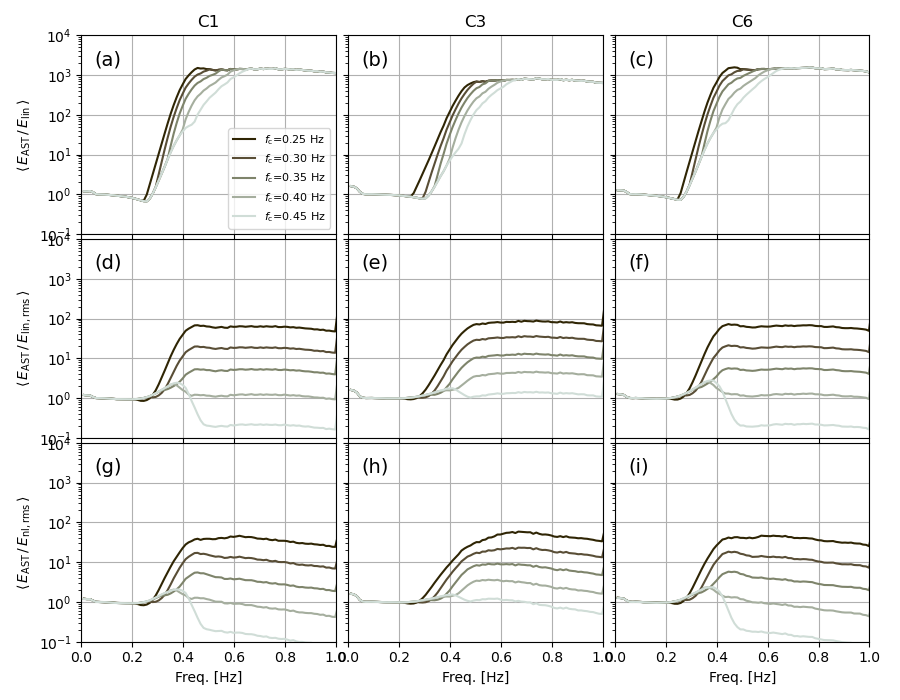

In [3]:
mids = ['C1', 'C3', 'C6'] # Mooring IDs
sers = ['103088', '103094', '103110'] # Serial numbers
tail_method = 'constant' # K_rms reconstruction tail method
lss = ['-', '--', ':'] # Linestyles for fc values in plots

# Initialize figure
fig, axes = plt.subplots(figsize=(9,7), nrows=3, ncols=3, sharex=True, sharey=True)
# Iterate over mooring IDs and serial numbers
for i, (mid, ser) in enumerate(zip(mids, sers)):
    # Initialize dicts to save diff. spectra
    d_lin = {'fc-0.25': [], 'fc-0.3': [], 'fc-0.35': [], 'fc-0.4': [], 'fc-0.45': []} # Linear
    d_link = {'fc-0.25': [], 'fc-0.3': [], 'fc-0.35': [], 'fc-0.4': [], 'fc-0.45': []} # Lin. K_rms
    d_nlk = {'fc-0.25': [], 'fc-0.3': [], 'fc-0.35': [], 'fc-0.4': [], 'fc-0.45': []} # Nonlin. K_rms
    # Signature velocity netcdf directory
    veldir = os.path.join(data_root, '{}'.format(ser)) 
    csvdir = os.path.join(veldir, 'p2eta')
    # Directory for spectral netcdf file
    ncdir = os.path.join(csvdir, 'spectra')
    # List all netcdf files
    fns_nc = sorted(glob.glob(os.path.join(ncdir, 'p2eta_spec*.nc')))
    # Iterate over spectral files
    for fn in fns_nc:
        # Read spectrum netcdf file
        dss = xr.open_dataset(fn)
        # Compute difference between AST and reconstructed spectra at different cutoffs
        for fc in [0.25, 0.3, 0.35, 0.4, 0.45]:
            # Linear reconstructions
            dss['Eld-{}'.format(fc)] = (['freq'], (dss['East'].values/dss['El-{}'.format(fc)].values))
            d_lin['fc-{}'.format(fc)].append(dss['Eld-{}'.format(fc)])
            dss['Elkd-{}'.format(fc)] = (['freq'], (dss['East'].values/dss['Elk-{}'.format(fc)].values))
            d_link['fc-{}'.format(fc)].append(dss['Elkd-{}'.format(fc)])
            dss['Enkd-{}'.format(fc)] = (['freq'], (dss['East'].values/dss['Enk-{}'.format(fc)].values))
            d_nlk['fc-{}'.format(fc)].append(dss['Enkd-{}'.format(fc)])
    # Concatenate spectra and plot mean diff and spread
    cs = ['#2F2504', '#594E36', '#7E846B', '#A5AE9E', '#D0DDD7']
    lw = 1.5 # Mean linewidth
    for fi, fc in enumerate([0.25, 0.3, 0.35, 0.4, 0.45]):
        # Linear 
        dsl = xr.concat(d_lin['fc-{}'.format(fc)], dim='time')
        # Mean diff. lin
        dsl.mean(dim='time').plot(ax=axes[0,i], color=cs[fi], linestyle='-', linewidth=lw,
                                  label=r'$f_\mathrm{c}$='+'{:.2f} Hz'.format(fc))
        # Linear K_rms
        dslk = xr.concat(d_link['fc-{}'.format(fc)], dim='time')
        # Mean diff. lin-K_rms
        dslk.mean(dim='time').plot(ax=axes[1,i], color=cs[fi], linestyle='-', linewidth=lw,
                                   )# label=r'$f_\mathrm{c}$='+'{}'.format(fc))
        # Nonlinear K_rms
        dsnk = xr.concat(d_nlk['fc-{}'.format(fc)], dim='time')
        # Mean diff. nl-K_rms
        dsnk.mean(dim='time').plot(ax=axes[2,i], color=cs[fi], linestyle='-', linewidth=lw,
                                   )# label=r'$f_\mathrm{c}$='+'{}'.format(fc))
    axes[0,i].set_title(mid)

ann = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
for a, ax in enumerate(axes.flat):
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xlim([0, 1])
    ax.set_ylim([1e-1, 1e4])
    ax.set_yscale('log')
    ax.grid()
    ax.annotate(ann[a], xy=(0.05,0.85), xycoords='axes fraction', fontsize=14)

axes[0,0].legend(loc='lower right', fontsize=8)
axes[2,0].set_xlabel('Freq. [Hz]')
axes[2,1].set_xlabel('Freq. [Hz]')
axes[2,2].set_xlabel('Freq. [Hz]')
axes[0,0].set_ylabel(r'$\langle \, E_\mathrm{AST} \, / \, E_\mathrm{lin} \, \rangle$')
axes[1,0].set_ylabel(r'$\langle \, E_\mathrm{AST} \, / \, E_\mathrm{lin, rms} \, \rangle$')
axes[2,0].set_ylabel(r'$\langle \, E_\mathrm{AST} \, / \, E_\mathrm{nl, rms} \, \rangle$')

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.025)
plt.show()


Compare zero-crossing wave/crest heights from AST against reconstructions.

In [3]:
mids = ['C1', 'C3', 'C6'] # Mooring IDs
sers = ['103088', '103094', '103110'] # Serial numbers
tail_method = 'constant' # K_rms reconstruction tail method
fcs = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5] # High-frequency cutoffs
prs = ['etal', 'etalk', 'etank'] # Reconstruction products
hstr = 'crestheight' # String for either 'waveheight' or 'crestheight'
mstr = 'C1' # Mooring ID to plot

# Initialize figure
fig, axes = plt.subplots(figsize=(9,6.5), nrows=3, ncols=5, sharex=True, sharey=True)
# Iterate over mooring IDs and find all timeseries-reconstruction csv files
for i, (mid, ser) in enumerate(zip(mids, sers)):
    if not mid == mstr:
        continue
    print('Mooring ID: ', mid)
    # Initialize dicts for wave and crest heights
    Hws = {'H-{}-{}'.format(pr, fc): [] for pr in prs for fc in fcs}
    # Add hyd & ast
    Hws['H-hyd'] = []
    Hws['H-ast'] = []
    Hcs = {'C-{}-{}'.format(pr, fc): [] for pr in prs for fc in fcs}
    # Add hyd & ast
    Hcs['C-hyd'] = []
    Hcs['C-ast'] = []
    timestamps = [] # List to store timestamps for dataframe index
    # Signature velocity netcdf directory
    veldir = os.path.join(data_root, '{}'.format(ser)) 
    csvdir = os.path.join(veldir, 'p2eta')
    # Define output dir. for csv files
    zcdir = os.path.join(csvdir, 'zero_crossings')
    # .csv filename
    fn_csv = os.path.join(zcdir, 'p2eta_{}_{}_{}.csv'.format(mid, ser, hstr))
    # Read csv
    dfz = pd.read_csv(fn_csv, parse_dates=['time']).set_index('time')
    # Plot scatter plots of each reconstruction against AST
    if hstr == 'crestheight':
        s = 'C'
    elif hstr == 'waveheight':
        s = 'H'
    x = dfz['{}-ast'.format(s)].values # x axis is always AST
    ims = [] # List to store images
    for pi, pr in enumerate(prs):
        for fi, fc in enumerate(fcs[:-1]):
            # Get y axis
            y = dfz['{}-{}-{}'.format(s, pr, fc)].values
            # Use 2D histogram for scatter plot
            _, _, _, im = axes[pi,fi].hist2d(x, y, norm=colors.LogNorm(), cmap=mpl.cm.gray, 
                                             bins=[50,50])
            # Save image to list
            ims.append(im)
            # Quantile-quantile plot
            rppl.qqplot(x, y, ax=axes[pi,fi], scatter=False, color='r')
            # Linear regression
            res = linregress(x, y)
            rmse = mean_squared_error(x, y, squared=False)
            xp = np.linspace(0, x.max())
            # Linear regression line
            axes[pi,fi].plot(xp, res.intercept + res.slope*xp, color='k', linewidth=1)
            # One-to-one line
            axes[pi,fi].plot(xp, xp, color='k', linestyle='--')
            # Annotate regression statistics
            rsq = r'$R^2$={:.2f}'.format(res.rvalue**2)
            fsz = 7
            axes[pi,fi].annotate(rsq, xy=(0.57, 0.18), xycoords="axes fraction", fontsize=fsz)
            rmsestr = 'RMSE={:.2f}'.format(rmse)
            axes[pi,fi].annotate(rmsestr, xy=(0.57, 0.1), xycoords="axes fraction", fontsize=fsz)
            bias = 'Bias={:.2f}'.format(res.slope - 1)
            axes[pi,fi].annotate(bias, xy=(0.57, 0.02), xycoords="axes fraction", fontsize=fsz)
            # Also annotate cutoff frequency
            axes[pi,fi].annotate(r'$f_\mathrm{c}$='+'{:.2f} Hz'.format(fc), xy=(0.05, 0.9), 
                xycoords="axes fraction", fontsize=fsz+1)
# Colorbar on upper left subplot
cax = axes[0,0].inset_axes([0.0, 1.04, 1, 0.05], transform=axes[0,0].transAxes)
cbar = fig.colorbar(ims[0], ax=axes[0,0], cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
# Common axis parameters
for ax in axes.flat:
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xlim([0, x.max()])
    ax.set_ylim([0, x.max()])
    ax.locator_params(axis='both', nbins=4)
    ax.grid(alpha=0.5)
# Axis labels
for ax in axes[-1,:]:
    ax.set_xlabel(r'$H_\mathrm{C}$ (AST) [m]')
axes[0,0].set_ylabel(r'$H_\mathrm{C}$ (lin) [m]')
axes[1,0].set_ylabel(r'$H_\mathrm{C}$ (lin-$\kappa_\mathrm{rms}$) [m]')
axes[2,0].set_ylabel(r'$H_\mathrm{C}$ (nl-$\kappa_\mathrm{rms}$) [m]')
# Save/show figure
plt.suptitle('{} {}-{}'.format(mstr, str(dfz.index[0].floor('20T')), str(dfz.index[-1].ceil('20T'))),
    y=0.92)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.025)
plt.show()


Mooring ID:  C1


In [9]:
plt.clf()